In [375]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [376]:
biomass_density = pd.read_csv('preprocessed/forecasted_unscaled.csv')

In [377]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [378]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [379]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [380]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [381]:
#new_distance = lambda den,dist: den/dist

In [382]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296,7.909043,17.154170
1,24.66818,71.41106,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945,33.303310,62.532272
2,24.66818,71.49069,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232,68.320305,106.519424
3,24.66818,71.57031,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352,91.012245,134.203400
4,24.66818,71.64994,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885,15.820264,29.635239


In [383]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [384]:
year = '2018'

### Get initial point with most density of biomass

In [385]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [386]:
k=10

In [387]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [388]:
weights=set_prob_depots(biomass_density[year])

In [389]:
def get_depots(k,year,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[year].shape[0],size=k,p=weights)
    return list(depots)

In [390]:
biomass_density[year].shape[0]

2418

In [391]:
depots = get_depots(k,year,weights)

### Visualising Data

In [392]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

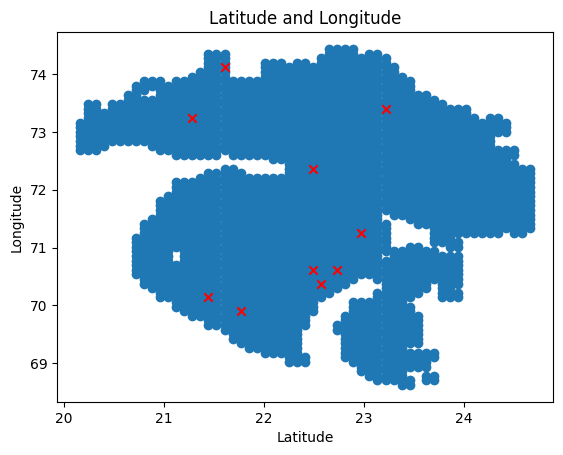

In [393]:
plot_depots(depots)

## Optimal clusters for depots

In [394]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        if len(X[belonging_to_cluster==i][['Latitude','Longitude']]) != 0:
            pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
            depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        else:
            depots = get_depots(k,year,weights)
            re_cluster_depots(k,X,depots)
        
    return depots,belonging_to_cluster

In [395]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1282, 2100, 429, 590, 625, 1625, 1948, 1321, 2073, 1522]
[1348, 2187, 215, 589, 692, 1625, 1728, 1257, 2122, 1463]
[1347, 2189, 215, 587, 692, 1681, 1552, 1258, 2123, 1335]
[1347, 2228, 214, 648, 626, 1681, 1489, 1258, 2077, 1210]
[1347, 2229, 214, 648, 625, 1681, 1489, 1324, 2077, 1099]
[1347, 2229, 214, 648, 564, 1681, 1429, 1325, 2077, 1045]
[1347, 2229, 213, 647, 564, 1681, 1429, 1392, 2078, 1045]
[1347, 2229, 174, 647, 503, 1681, 1429, 1392, 2078, 990]
[1347, 2229, 174, 647, 503, 1681, 1363, 1393, 2078, 928]
[1346, 2229, 174, 646, 502, 1626, 1363, 1393, 2078, 865]
[1411, 2229, 174, 646, 501, 1682, 1297, 1394, 2078, 799]
[1411, 2229, 174, 646, 445, 1681, 1238, 1394, 2078, 799]
[1474, 2190, 173, 646, 445, 1626, 1239, 1394, 2078, 799]
[1474, 2190, 173, 646, 445, 1682, 1239, 1394, 2078, 799]
[1474, 2190, 173, 646, 445, 1681, 1239, 1394, 2078, 799]
[1474, 2190, 173, 646, 445, 1626, 1239, 1394, 2077, 799]
[1535, 2190, 173, 646, 445, 1626, 1239, 1394, 2077, 799]
Convergence in : 17 iter

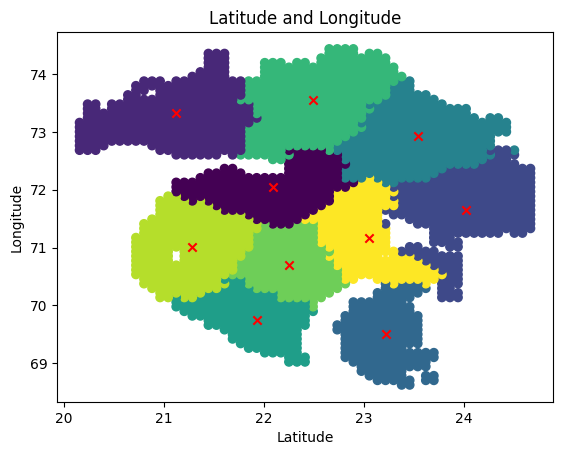

In [396]:
plot_depots(depots,clusters)

## Finding refineries

In [397]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296,7.909043,17.154170
1,24.66818,71.41106,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945,33.303310,62.532272
2,24.66818,71.49069,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232,68.320305,106.519424
3,24.66818,71.57031,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352,91.012245,134.203400
4,24.66818,71.64994,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885,15.820264,29.635239
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,5.199882,4.516778,4.321080,2.658953,5.113997,5.301668,6.419223,5.321604,5.280633,18.673874
2414,20.15456,72.92394,0.122287,0.126717,0.101494,0.111509,0.121749,0.122467,0.145785,0.120626,0.161665,0.444787
2415,20.15456,73.00357,0.039415,0.040843,0.032713,0.035941,0.039241,0.039473,0.046989,0.038879,0.060271,0.146884
2416,20.15456,73.08319,2.719220,1.370163,0.818687,1.205721,1.316443,1.324201,1.576338,1.304297,2.200899,14.368222


In [398]:
def biomass_per_depo(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
        #print(biomass)
    return biomass

In [399]:
biomass_per_depot=biomass_per_depo(k,clusters,year)
biomass_per_depot

[49205.26365307004,
 32910.20960105999,
 33248.808417295,
 4251.411716997998,
 43737.16121762997,
 28353.850199179,
 50233.382765147995,
 70507.83964169999,
 58384.952167788986,
 49281.22903473397]

In [400]:
depots

[1535, 2190, 173, 646, 445, 1626, 1239, 1394, 2077, 799]

In [401]:
r=5

In [402]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [403]:
biomass_per_depot

[49205.26365307004,
 32910.20960105999,
 33248.808417295,
 4251.411716997998,
 43737.16121762997,
 28353.850199179,
 50233.382765147995,
 70507.83964169999,
 58384.952167788986,
 49281.22903473397]

In [404]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.11712356873411703,
 0.07833635896031729,
 0.07914232764704573,
 0.010119659473093338,
 0.10410781342879007,
 0.0674908307797107,
 0.11957080649996545,
 0.16783021143416849,
 0.13897403347894696,
 0.11730438956384495]

In [405]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    #print(refineries_index)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [406]:
get_refineries(5,depots,weights)

[1394, 1239, 1394, 2077, 2190]

In [407]:
refineries = get_refineries(r,depots,weights)
refineries

[1626, 2190, 1394, 1535, 1394]

## Optimal clusters for refineries

In [408]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
        
    X=np.array(X)
    refineries = []
    for i in range(r):
        if len(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy()) != 0:
            pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(), axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
            refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
        else:
            refineries = get_refineries(r,depots,weights)
            re_cluster_refineries(r,X,refineries)
    return refineries,belonging_to_cluster

In [409]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 3 iterations


In [410]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [411]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

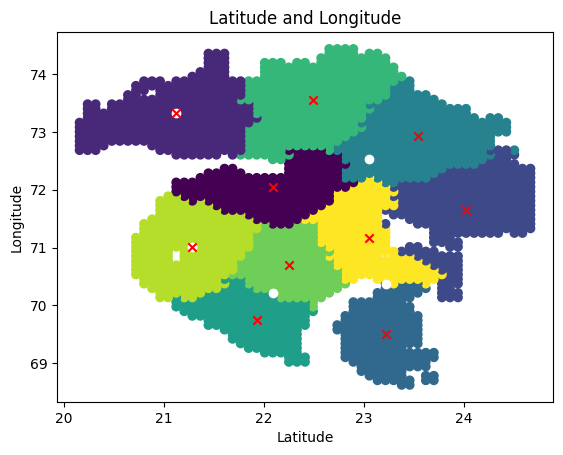

In [412]:
plot_depots(depots,clusters,refineries)

## Loss function for depots

In [413]:
biomass_per_depot

[49205.26365307004,
 32910.20960105999,
 33248.808417295,
 4251.411716997998,
 43737.16121762997,
 28353.850199179,
 50233.382765147995,
 70507.83964169999,
 58384.952167788986,
 49281.22903473397]

In [414]:
biomass_per_refinery

[176424.616053143,
 98861.68984087899,
 32910.20960105999,
 58384.952167788986,
 53532.640751731975]

In [415]:
clusters

array([2., 2., 2., ..., 1., 1., 1.])

In [416]:
cluster_depots

array([0., 2., 0., 4., 0., 1., 0., 1., 3., 4.])

In [417]:
depots

[1535, 2190, 173, 646, 445, 1626, 1239, 1394, 2077, 799]

In [418]:
refineries

[816, 1512, 2190, 2077, 657]

In [419]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum([biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index]))
    #print(loss)
    return sum(loss)

In [420]:
def loss_refinery(refineries,cluster_depots,depots):
    loss=[]
    refineries=np.array(refineries)
    depots = np.array(depots)
    for i in range(len(refineries)):
        loss.append(sum([biomass_per_depot[x]*distance_matrix.iloc[depots[x],refineries[i]] for x in np.where(depots[cluster_depots==i])[0]]))
    #print(loss)
    return sum(loss)

In [421]:
loss_depot(depots,year)

29124262.774079088

In [422]:
loss_refinery(refineries,cluster_depots,depots)

115797675.26536214

### Optimal number for depots (2018)

In [423]:
k=range(1,26)

Convergence in : 1 iterations


Convergence in : 4 iterations
Convergence in : 10 iterations
Convergence in : 8 iterations
Convergence in : 10 iterations
Convergence in : 23 iterations
Convergence in : 30 iterations
Convergence in : 10 iterations
Convergence in : 9 iterations
Convergence in : 8 iterations
Convergence in : 10 iterations
Convergence in : 23 iterations
Convergence in : 13 iterations
Convergence in : 19 iterations
Convergence in : 20 iterations
Convergence in : 12 iterations
Convergence in : 13 iterations
Convergence in : 19 iterations
Convergence in : 10 iterations
Convergence in : 12 iterations
Convergence in : 10 iterations
Convergence in : 30 iterations
Convergence in : 19 iterations
Convergence in : 15 iterations
Convergence in : 21 iterations


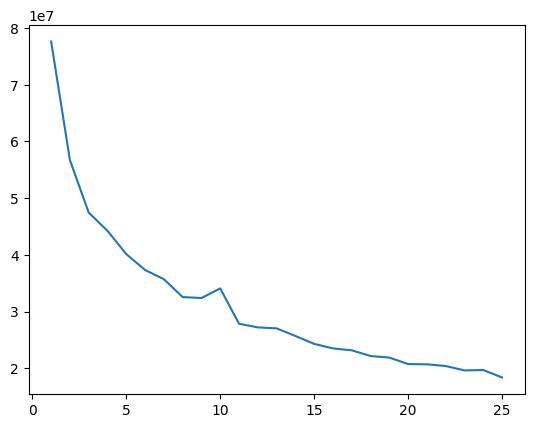

In [424]:
loss_d=[]
year = '2018'
for i in k:
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

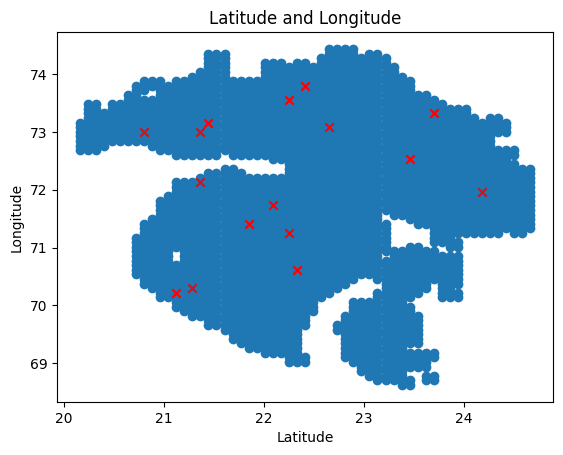

In [425]:
k_2018 = 16
weights = set_prob_depots(density=biomass_density[year])
depots_2018 = get_depots(k_2018,year,weights)
plot_depots(depots_2018)

In [426]:
count=0
clusters_2018=[]
for _ in range(30):
    prev=depots_2018
    depots_2018,clusters_2018=re_cluster_depots(k_2018,biomass_density,depots_2018)
    if np.array_equal(prev,depots_2018):
        break
    print(depots_2018)
    count+=1
print(f"Convergence in : {count} iterations")

[1343, 147, 553, 1861, 2099, 1885, 2356, 1906, 356, 1121, 1100, 2113, 1550, 2087, 1189, 916]
[1344, 146, 552, 1860, 2146, 1886, 2367, 1629, 355, 1121, 1043, 2201, 1549, 2087, 1025, 648]
[1343, 145, 492, 1859, 2146, 1887, 2376, 1569, 312, 1067, 987, 2162, 1549, 2087, 962, 647]
[1343, 145, 491, 1859, 2146, 1888, 2376, 1568, 271, 1012, 986, 2162, 1548, 2087, 962, 646]
[1343, 145, 491, 1806, 2146, 1889, 2376, 1568, 270, 1011, 923, 2162, 1548, 2087, 962, 646]
[1277, 122, 490, 1805, 2146, 1947, 2376, 1568, 270, 1011, 859, 2162, 1548, 2087, 962, 645]
[1276, 123, 490, 1751, 2145, 2004, 2376, 1507, 270, 1011, 728, 2162, 1548, 2037, 962, 645]
[1276, 98, 549, 1751, 2098, 2004, 2376, 1507, 270, 1011, 728, 2162, 1548, 2037, 962, 645]
[1276, 98, 549, 1751, 2098, 2058, 2376, 1507, 270, 1011, 728, 2162, 1548, 2037, 962, 645]
Convergence in : 9 iterations


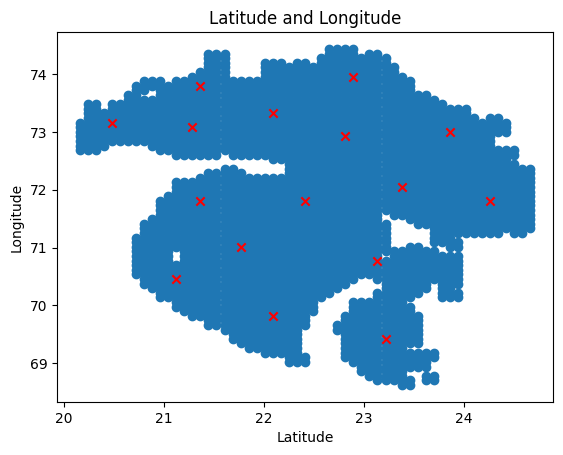

In [427]:
plot_depots(depots_2018)

In [428]:
bpd_2018 = biomass_per_depo(k_2018,clusters_2018,year)

### Optimal Number of refineries (2018)

In [429]:
r = range(1,6)

Convergence in : 1 iterations


Convergence in : 2 iterations
Convergence in : 3 iterations
Convergence in : 5 iterations
Convergence in : 2 iterations


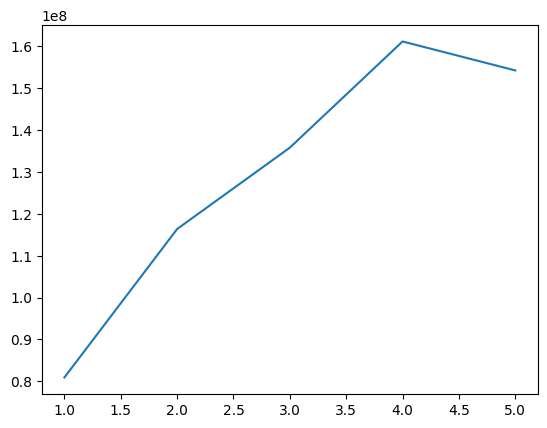

In [430]:
loss_r=[]
year = '2018'
for i in r:
    biomass_per_depot = biomass_per_depo(k_2018,clusters_2018,year)
    weights = set_prob_ref(bpd_2018)
    #print(weights)
    refineries = get_refineries(i,depots_2018,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots_2018,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots_2018))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [431]:
r_2018 = 3

In [432]:
weights=set_prob_ref(bpd_2018)
refineries_2018 = get_refineries(r_2018,depots_2018,weights)

In [433]:
count=0
clusters_depots_2018=[]
for _ in range(30):
    prev=refineries_2018
    refineries_2018,clusters_depots_2018=re_cluster_refineries(r_2018,depots_2018,refineries_2018)
    if np.array_equal(prev,refineries_2018):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 6 iterations


In [434]:
bpr_2018 = biomass_per_refineries(r_2018,clusters_depots_2018,bpd_2018)

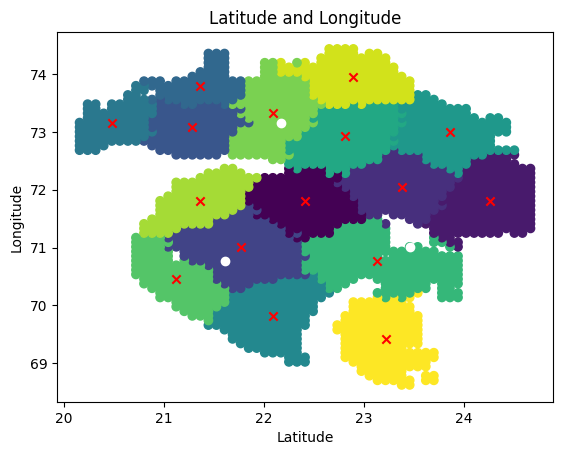

In [435]:
plot_depots(depots_2018,clusters_2018,refineries_2018)

### Optimal number for depots (2019)

In [436]:
k=range(1,26)

In [437]:
year = '2019'

Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 2 iterations
Convergence in : 8 iterations
Convergence in : 6 iterations
Convergence in : 4 iterations
Convergence in : 9 iterations
Convergence in : 10 iterations
Convergence in : 7 iterations
Convergence in : 12 iterations
Convergence in : 11 iterations
Convergence in : 13 iterations
Convergence in : 21 iterations
Convergence in : 25 iterations
Convergence in : 21 iterations
Convergence in : 18 iterations
Convergence in : 30 iterations
Convergence in : 10 iterations
Convergence in : 17 iterations
Convergence in : 30 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 14 iterations
Convergence in : 16 iterations
Convergence in : 16 iterations


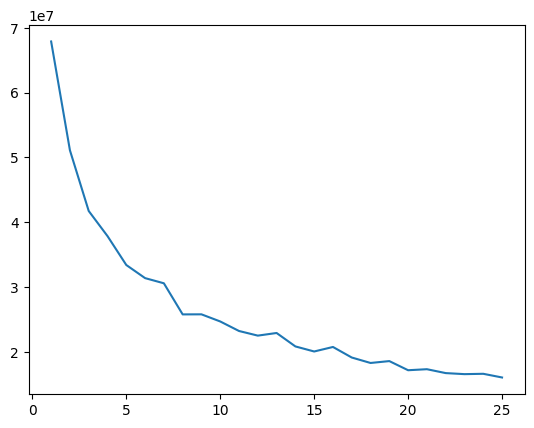

In [438]:
loss_d=[]
year = '2019'
for i in k:

    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

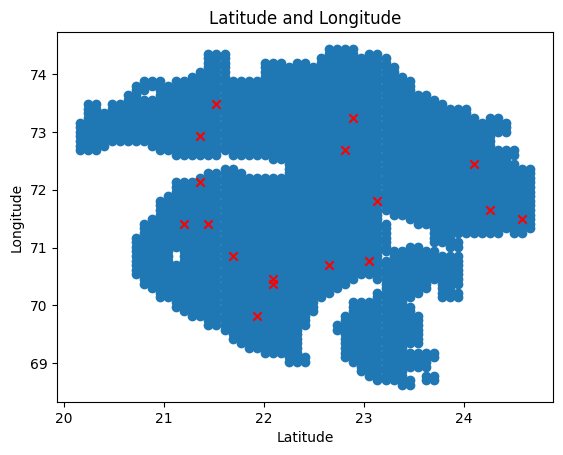

In [439]:
k_2019 = 17
weights = set_prob_depots(density=biomass_density[year])
depots_2019 = get_depots(k_2019,year,weights)
plot_depots(depots_2019)

In [440]:
count=0
clusters_2019=[]
for _ in range(30):
    prev=depots_2019
    depots_2019,clusters_2019 = re_cluster_depots(k_2019,biomass_density,depots_2019)
    if np.array_equal(prev,depots_2019):
        break
    print(depots_2019)
    count+=1
print(f"Convergence in : {count} iterations")

[590, 1911, 957, 1889, 17, 1863, 147, 1388, 1818, 2249, 1062, 1149, 872, 185, 1577, 2186, 1626]
[586, 2021, 959, 1836, 35, 1810, 209, 1322, 1763, 2248, 1063, 1095, 807, 225, 1637, 2226, 1625]
[646, 2069, 1022, 1779, 54, 1810, 287, 1322, 1709, 2249, 1118, 1041, 807, 267, 1638, 2295, 1624]
[645, 2069, 1022, 1778, 76, 1863, 327, 1322, 1654, 2250, 1118, 986, 808, 308, 1638, 2321, 1565]
[645, 2069, 1022, 1833, 99, 1863, 372, 1322, 1654, 2212, 1173, 986, 742, 308, 1639, 2322, 1565]
[645, 2069, 1022, 1833, 99, 1863, 371, 1322, 1654, 2212, 1173, 987, 743, 309, 1580, 2322, 1565]
[645, 2069, 1022, 1833, 99, 1863, 371, 1322, 1654, 2212, 1229, 987, 743, 309, 1580, 2322, 1565]
[645, 2069, 1022, 1833, 99, 1863, 371, 1322, 1654, 2212, 1229, 987, 743, 351, 1580, 2322, 1565]
[645, 2069, 1022, 1833, 125, 1863, 371, 1322, 1654, 2212, 1229, 987, 743, 352, 1580, 2322, 1565]
Convergence in : 9 iterations


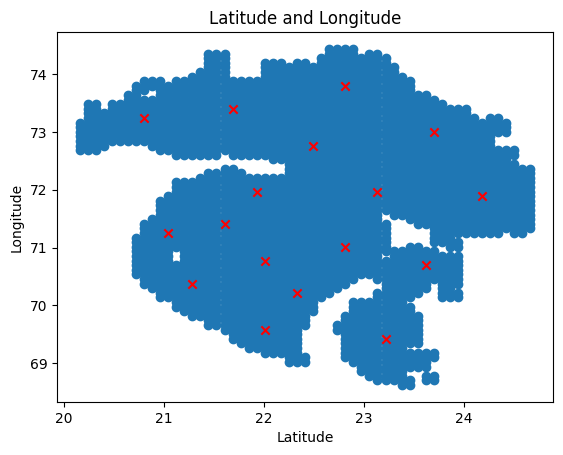

In [441]:
plot_depots(depots_2019)

In [442]:
bpd_2019 = biomass_per_depo(k_2019,clusters_2019,year)

### Optimal Number of refineries (2019)

In [443]:
r = range(1,6)

Convergence in : 1 iterations


Convergence in : 2 iterations
Convergence in : 3 iterations
Convergence in : 3 iterations
Convergence in : 7 iterations


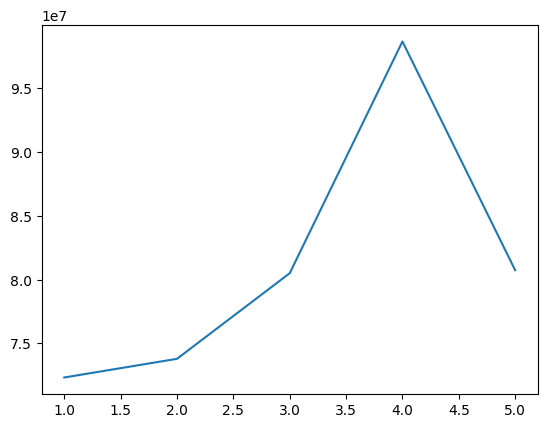

In [444]:
loss_r=[]
for i in r:
    year = '2019'
    biomass_per_depot = biomass_per_depo(k_2019,clusters_2019,year)
    weights = set_prob_ref(bpd_2019)
    #print(weights)
    refineries = get_refineries(i,depots_2019,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots_2019,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots_2019))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [622]:
r_2019=4

In [446]:
weights = set_prob_ref(bpd_2019)
refineries_2019 = get_refineries(r_2019,depots_2019,weights)

In [623]:
count=0
clusters_depots_2019=[]
for _ in range(30):
    prev=refineries_2019
    refineries_2019,cluster_depots_2019 = re_cluster_refineries(r_2019,depots_2019,refineries_2019)
    if np.array_equal(prev,refineries_2019):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 0 iterations


In [448]:
bpr_2019 = biomass_per_refineries(r_2019,cluster_depots_2019,bpd_2019)

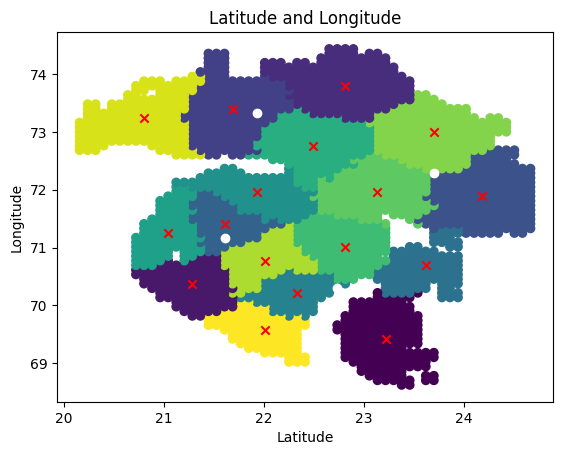

In [449]:
plot_depots(depots_2019,clusters_2019,refineries_2019)

## Combined data for 2018 and 2019

In [450]:
biomass_density['20182019'] = (biomass_density['2018'] + biomass_density['2019']) / 2

In [451]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,20182019
0,24.66818,71.33144,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296,7.909043,17.154170,12.531607
1,24.66818,71.41106,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945,33.303310,62.532272,47.917791
2,24.66818,71.49069,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232,68.320305,106.519424,87.419865
3,24.66818,71.57031,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352,91.012245,134.203400,112.607822
4,24.66818,71.64994,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885,15.820264,29.635239,22.727752


### Optimal number for depots (20182019)

In [474]:
k=range(1,26)
year = '20182019'

Convergence in : 1 iterations
Convergence in : 6 iterations
Convergence in : 8 iterations
Convergence in : 4 iterations
Convergence in : 7 iterations
Convergence in : 30 iterations
Convergence in : 10 iterations
Convergence in : 8 iterations
Convergence in : 12 iterations
Convergence in : 17 iterations
Convergence in : 25 iterations
Convergence in : 10 iterations
Convergence in : 30 iterations
Convergence in : 9 iterations
Convergence in : 9 iterations
Convergence in : 10 iterations
Convergence in : 15 iterations
Convergence in : 25 iterations
Convergence in : 10 iterations
Convergence in : 30 iterations
Convergence in : 13 iterations
Convergence in : 8 iterations
Convergence in : 12 iterations
Convergence in : 14 iterations
Convergence in : 11 iterations


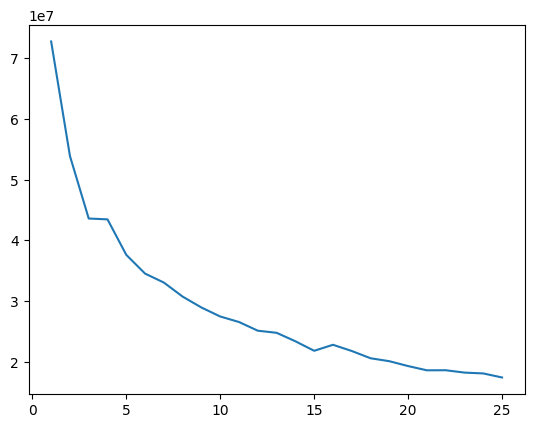

In [475]:
loss_d=[]
for i in k:
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

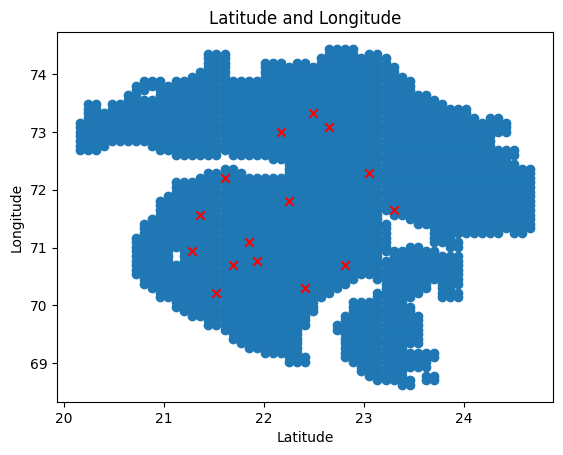

In [476]:
k_1819 = 15
weights = set_prob_depots(density=biomass_density[year])
depots_1819 = get_depots(k_1819,year,weights)
plot_depots(depots_1819)

In [477]:
count=0
clusters_1819=[]
for _ in range(30):
    prev=depots_1819
    depots_1819,clusters_1819=re_cluster_depots(k_1819,biomass_density,depots_1819)
    if np.array_equal(prev,depots_1819):
        break
    print(depots_1819)
    count+=1
print(f"Convergence in : {count} iterations")

[1384, 1700, 1519, 213, 1186, 2084, 2100, 2208, 1801, 440, 758, 1871, 654, 1342, 1902]
[1446, 1701, 1204, 148, 1242, 2130, 2147, 2244, 1853, 389, 758, 1871, 589, 1162, 1902]
[1445, 1701, 1094, 146, 1241, 2130, 2147, 2244, 1853, 346, 759, 1818, 586, 1107, 1902]
[1445, 1700, 985, 145, 1299, 2130, 2189, 2244, 1800, 305, 759, 1764, 646, 1054, 1902]
[1445, 1645, 859, 145, 1364, 2130, 2189, 2244, 1800, 265, 759, 1710, 645, 999, 1902]
[1445, 1585, 794, 146, 1364, 2130, 2190, 2244, 1800, 224, 760, 1654, 645, 999, 1902]
[1445, 1462, 661, 147, 1363, 2083, 2190, 2244, 1800, 224, 761, 1709, 645, 938, 1902]
[1445, 1399, 599, 147, 1428, 2083, 2229, 2244, 1800, 225, 762, 1654, 645, 939, 1902]
[1445, 1267, 599, 123, 1487, 2083, 2229, 2244, 1801, 226, 763, 1653, 645, 876, 1902]
[1445, 1208, 539, 124, 1487, 2084, 2229, 2244, 1801, 226, 830, 1653, 645, 877, 1902]
[1445, 1097, 420, 124, 1487, 2084, 2229, 2244, 1802, 227, 831, 1594, 645, 878, 1902]
[1445, 1096, 370, 125, 1487, 2085, 2229, 2244, 1748, 269, 

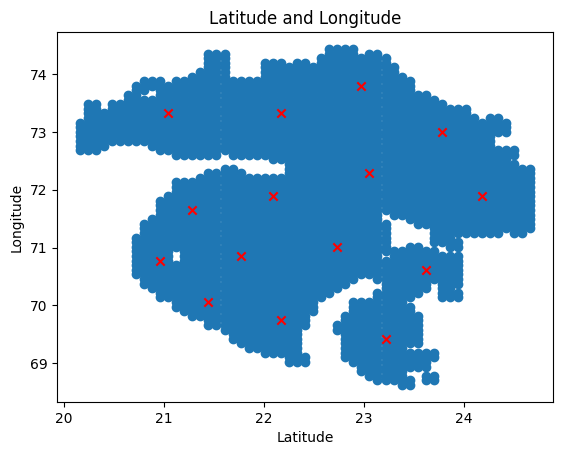

In [478]:
plot_depots(depots_1819)

In [479]:
bpd_1819 = biomass_per_depo(k_1819,clusters_1819,year)

### Optimal Number of refineries (20182019)

In [480]:
r_1819 = range(1,6)

Convergence in : 1 iterations
Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 6 iterations
Convergence in : 3 iterations


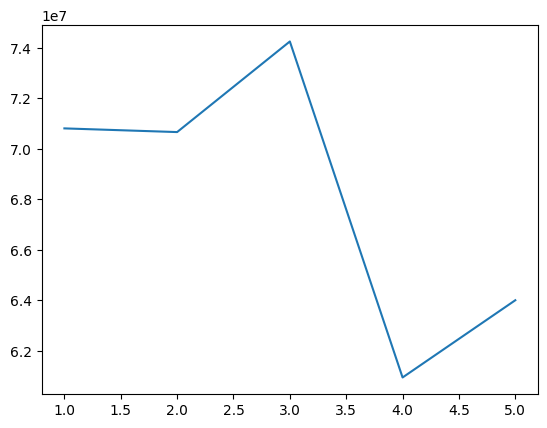

In [481]:
loss_r=[]
year = '20182019'
for i in r:
    weights = set_prob_ref(bpd_1819)
    refineries = get_refineries(i,depots_1819,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots_1819,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots_1819))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)

In [482]:
r_1819 = 4

In [483]:
weights=set_prob_ref(bpd_1819)
refineries_1819 = get_refineries(r_1819,depots_1819,weights)

In [484]:
count=0
clusters_depots_1819=[]
for _ in range(30):
    prev=refineries_1819
    refineries_1819,cluster_depots_1819 = re_cluster_refineries(r_1819,depots_1819,refineries_1819)
    if np.array_equal(prev,refineries_1819):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 2 iterations


In [485]:
bpr_1819 = biomass_per_refineries(r_1819,cluster_depots_1819,bpd_1819)

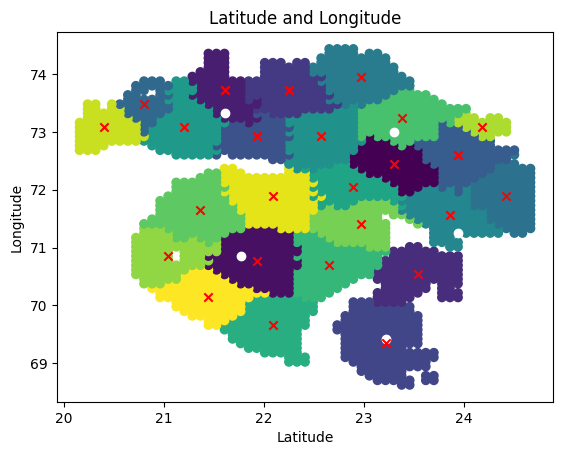

In [486]:
plot_depots(depots,clusters,refineries)

## Submission file pre processing

In [572]:
columns = ['year','data_type','source_index','destination_index','value']

In [573]:
depots_1819

[1445,
 1042,
 370,
 125,
 1487,
 2085,
 2229,
 2244,
 1749,
 310,
 897,
 1533,
 645,
 813,
 1960]

In [605]:
def preprocessing_depot_1819(depots_1819,columns):
    year=['20182019' for i in range(len(depots_1819))]
    data_type=['depot_location' for i in range(len(depots_1819))]
    destination_index = [np.nan for i in range(len(depots_1819))]
    value = [np.nan for i in range(len(depots_1819))]
    return pd.DataFrame(list(zip(year,data_type,depots_1819,destination_index,value)),columns=columns)
    

In [490]:
preprocessing_depot_1819(depots_1819,columns)

,year,data_type,source_index,destination_index,value
0,20182019,depot_location,1445,None,None
1,20182019,depot_location,1042,None,None
2,20182019,depot_location,370,None,None
3,20182019,depot_location,125,None,None
4,20182019,depot_location,1487,None,None
5,20182019,depot_location,2085,None,None
6,20182019,depot_location,2229,None,None
7,20182019,depot_location,2244,None,None
8,20182019,depot_location,1749,None,None
9,20182019,depot_location,310,None,None


In [575]:
refineries_1819

[330, 1359, 1576, 1977]

In [600]:
def preprocessing_refineries_1819(refineries_1819,columns):
    year=['20182019' for i in range(len(refineries_1819))]
    data_type=['refinery_location' for i in range(len(refineries_1819))]
    destination_index = [ np.nan for i in range(len(refineries_1819))]
    value = [np.nan for i in range(len(refineries_1819))]
    return pd.DataFrame(list(zip(year,data_type,refineries_1819,destination_index,value)),columns=columns,index=None)

In [577]:
preprocessing_refineries_1819(refineries_1819,columns)

,year,data_type,source_index,destination_index,value
0,20182019,refinery_location,330,None,None
1,20182019,refinery_location,1359,None,None
2,20182019,refinery_location,1576,None,None
3,20182019,refinery_location,1977,None,None


In [578]:
biomass_density[['2018','2019']]

,2018,2019
0,7.909043,17.154170
1,33.303310,62.532272
2,68.320305,106.519424
3,91.012245,134.203400
4,15.820264,29.635239
...,...,...
2413,5.280633,18.673874
2414,0.161665,0.444787
2415,0.060271,0.146884
2416,2.200899,14.368222


In [579]:
cluster_depots_1819

array([2., 2., 0., 0., 1., 3., 1., 3., 2., 0., 1., 3., 0., 1., 2.])

In [580]:
biomass_density['2018'].index

RangeIndex(start=0, stop=2418, step=1)

In [608]:
def arrange_biomass_dataframe(density,columns,year):
    length = len(density)
    year = [year]*length
    data_type = ['biomass_forecast']*length
    index = [x for x in range(length)]
    return pd.DataFrame(list(zip(year,data_type,index,[np.nan]*length,density)),columns=columns)

In [609]:
arrange_biomass_dataframe(biomass_density['2018'],columns,'2018')

,year,data_type,source_index,destination_index,value
0,2018,biomass_forecast,0,NaN,7.909043
1,2018,biomass_forecast,1,NaN,33.303310
2,2018,biomass_forecast,2,NaN,68.320305
3,2018,biomass_forecast,3,NaN,91.012245
4,2018,biomass_forecast,4,NaN,15.820264
...,...,...,...,...,...
2413,2018,biomass_forecast,2413,NaN,5.280633
2414,2018,biomass_forecast,2414,NaN,0.161665
2415,2018,biomass_forecast,2415,NaN,0.060271
2416,2018,biomass_forecast,2416,NaN,2.200899


In [555]:
pd.DataFrame(clusters_2018).value_counts()

10.0    223
3.0     193
1.0     188
7.0     177
15.0    172
9.0     161
12.0    158
8.0     156
2.0     155
0.0     153
14.0    141
11.0    126
13.0    121
4.0     120
6.0      94
5.0      80
Name: count, dtype: int64

In [543]:
depots_dict = dict(enumerate(depots_2018))
depots_dict

{0: 1276,
 1: 98,
 2: 549,
 3: 1751,
 4: 2098,
 5: 2058,
 6: 2376,
 7: 1507,
 8: 270,
 9: 1011,
 10: 728,
 11: 2162,
 12: 1548,
 13: 2037,
 14: 962,
 15: 645}

In [588]:
def biomass_demand_supply(year,cluster,depots,density):
    length=len(cluster)
    year = [year]*length
    data_type = ['biomass_demand_supply']*length
    source,dest=[],[]
    depots_dict = dict(enumerate(depots))
    for i in range(length):
        source.append(i)
        dest.append(depots_dict[cluster[i]])

    return pd.DataFrame(list(zip(year,data_type,source,dest,density)),columns=columns)
        
biomass_demand_supply('2018',clusters_2018,depots_2018,biomass_density['2018'])

 
    

,year,data_type,source_index,destination_index,value
0,2018,biomass_demand_supply,0,98,7.909043
1,2018,biomass_demand_supply,1,98,33.303310
2,2018,biomass_demand_supply,2,98,68.320305
3,2018,biomass_demand_supply,3,98,91.012245
4,2018,biomass_demand_supply,4,98,15.820264
...,...,...,...,...,...
2413,2018,biomass_demand_supply,2413,2376,5.280633
2414,2018,biomass_demand_supply,2414,2376,0.161665
2415,2018,biomass_demand_supply,2415,2376,0.060271
2416,2018,biomass_demand_supply,2416,2376,2.200899


In [589]:
arrage_biomass_dataframe(biomass_density['2019'],columns,'2019')

,year,data_type,source_index,destination_index,value
0,2019,biomass_forecast,0,None,17.154170
1,2019,biomass_forecast,1,None,62.532272
2,2019,biomass_forecast,2,None,106.519424
3,2019,biomass_forecast,3,None,134.203400
4,2019,biomass_forecast,4,None,29.635239
...,...,...,...,...,...
2413,2019,biomass_forecast,2413,None,18.673874
2414,2019,biomass_forecast,2414,None,0.444787
2415,2019,biomass_forecast,2415,None,0.146884
2416,2019,biomass_forecast,2416,None,14.368222


In [557]:
depots_2018

[1276,
 98,
 549,
 1751,
 2098,
 2058,
 2376,
 1507,
 270,
 1011,
 728,
 2162,
 1548,
 2037,
 962,
 645]

In [569]:
pd.DataFrame(clusters_depots_2018)

,0
0,0.0
1,2.0
2,2.0
3,1.0
4,0.0
5,0.0
6,0.0
7,1.0
8,0.0
9,0.0


In [561]:
refineries_2018

[1485, 1855, 481]

In [571]:
def pellet_demand_supply(year,cluster,refineries,density,depots):
    length=len(cluster)
    year = [year]*length
    data_type = ['pellet_demand_supply']*length
    source,dest=[],[]
    refineries_dict = dict(enumerate(refineries))
    for i in range(length):
        source.append(depots[i])
        dest.append(refineries_dict[cluster[i]])

    return pd.DataFrame(list(zip(year,data_type,source,dest,density)),columns=columns)
        
pellet_demand_supply('2018',clusters_depots_2018,refineries_2018,bpd_2018,depots_2018)

,year,data_type,source_index,destination_index,value
0,2018,pellet_demand_supply,1276,1485,41472.519011
1,2018,pellet_demand_supply,98,481,19454.103981
2,2018,pellet_demand_supply,549,481,33333.171542
3,2018,pellet_demand_supply,1751,1855,74111.436439
4,2018,pellet_demand_supply,2098,1485,20500.266729
5,2018,pellet_demand_supply,2058,1485,3879.796986
6,2018,pellet_demand_supply,2376,1485,4924.035475
7,2018,pellet_demand_supply,1507,1855,37297.910973
8,2018,pellet_demand_supply,270,1485,19907.445753
9,2018,pellet_demand_supply,1011,1485,31510.631042


# Submission Final

In [590]:
columns = ['year','data_type','source_index','destination_index','value']

In [606]:
depot_location_1819 = preprocessing_depot_1819(depots_1819,columns)
depot_location_1819

,year,data_type,source_index,destination_index,value
0,20182019,depot_location,1445,NaN,NaN
1,20182019,depot_location,1042,NaN,NaN
2,20182019,depot_location,370,NaN,NaN
3,20182019,depot_location,125,NaN,NaN
4,20182019,depot_location,1487,NaN,NaN
5,20182019,depot_location,2085,NaN,NaN
6,20182019,depot_location,2229,NaN,NaN
7,20182019,depot_location,2244,NaN,NaN
8,20182019,depot_location,1749,NaN,NaN
9,20182019,depot_location,310,NaN,NaN


In [607]:
refinery_location_1819=preprocessing_refineries_1819(refineries_1819,columns)
refinery_location_1819

,year,data_type,source_index,destination_index,value
0,20182019,refinery_location,330,NaN,NaN
1,20182019,refinery_location,1359,NaN,NaN
2,20182019,refinery_location,1576,NaN,NaN
3,20182019,refinery_location,1977,NaN,NaN


In [611]:
biomass_forecast_2018 = arrange_biomass_dataframe(biomass_density['2018'],columns,'2018')
biomass_forecast_2018

,year,data_type,source_index,destination_index,value
0,2018,biomass_forecast,0,NaN,7.909043
1,2018,biomass_forecast,1,NaN,33.303310
2,2018,biomass_forecast,2,NaN,68.320305
3,2018,biomass_forecast,3,NaN,91.012245
4,2018,biomass_forecast,4,NaN,15.820264
...,...,...,...,...,...
2413,2018,biomass_forecast,2413,NaN,5.280633
2414,2018,biomass_forecast,2414,NaN,0.161665
2415,2018,biomass_forecast,2415,NaN,0.060271
2416,2018,biomass_forecast,2416,NaN,2.200899


In [613]:
biomass_demand_supply_2018=biomass_demand_supply('2018',clusters_2018,depots_2018,biomass_density['2018'])
biomass_demand_supply_2018

,year,data_type,source_index,destination_index,value
0,2018,biomass_demand_supply,0,98,7.909043
1,2018,biomass_demand_supply,1,98,33.303310
2,2018,biomass_demand_supply,2,98,68.320305
3,2018,biomass_demand_supply,3,98,91.012245
4,2018,biomass_demand_supply,4,98,15.820264
...,...,...,...,...,...
2413,2018,biomass_demand_supply,2413,2376,5.280633
2414,2018,biomass_demand_supply,2414,2376,0.161665
2415,2018,biomass_demand_supply,2415,2376,0.060271
2416,2018,biomass_demand_supply,2416,2376,2.200899


In [614]:
pellet_demand_supply_2018=pellet_demand_supply('2018',clusters_depots_2018,refineries_2018,bpd_2018,depots_2018)
pellet_demand_supply_2018

,year,data_type,source_index,destination_index,value
0,2018,pellet_demand_supply,1276,1485,41472.519011
1,2018,pellet_demand_supply,98,481,19454.103981
2,2018,pellet_demand_supply,549,481,33333.171542
3,2018,pellet_demand_supply,1751,1855,74111.436439
4,2018,pellet_demand_supply,2098,1485,20500.266729
5,2018,pellet_demand_supply,2058,1485,3879.796986
6,2018,pellet_demand_supply,2376,1485,4924.035475
7,2018,pellet_demand_supply,1507,1855,37297.910973
8,2018,pellet_demand_supply,270,1485,19907.445753
9,2018,pellet_demand_supply,1011,1485,31510.631042


In [615]:
biomass_forecast_2019 = arrange_biomass_dataframe(biomass_density['2019'],columns,'2019')
biomass_forecast_2019

,year,data_type,source_index,destination_index,value
0,2019,biomass_forecast,0,NaN,17.154170
1,2019,biomass_forecast,1,NaN,62.532272
2,2019,biomass_forecast,2,NaN,106.519424
3,2019,biomass_forecast,3,NaN,134.203400
4,2019,biomass_forecast,4,NaN,29.635239
...,...,...,...,...,...
2413,2019,biomass_forecast,2413,NaN,18.673874
2414,2019,biomass_forecast,2414,NaN,0.444787
2415,2019,biomass_forecast,2415,NaN,0.146884
2416,2019,biomass_forecast,2416,NaN,14.368222


In [616]:
biomass_demand_supply_2019=biomass_demand_supply('2019',clusters_2018,depots_2019,biomass_density['2019'])
biomass_demand_supply_2019

,year,data_type,source_index,destination_index,value
0,2019,biomass_demand_supply,0,2069,17.154170
1,2019,biomass_demand_supply,1,2069,62.532272
2,2019,biomass_demand_supply,2,2069,106.519424
3,2019,biomass_demand_supply,3,2069,134.203400
4,2019,biomass_demand_supply,4,2069,29.635239
...,...,...,...,...,...
2413,2019,biomass_demand_supply,2413,371,18.673874
2414,2019,biomass_demand_supply,2414,371,0.444787
2415,2019,biomass_demand_supply,2415,371,0.146884
2416,2019,biomass_demand_supply,2416,371,14.368222


In [628]:
pellet_demand_supply_2019=pellet_demand_supply('2019',cluster_depots_2019,refineries_2019,bpd_2019,depots_2019)
pellet_demand_supply_2019

,year,data_type,source_index,destination_index,value
0,2019,pellet_demand_supply,645,1033,6086.521693
1,2019,pellet_demand_supply,2069,1860,12891.352252
2,2019,pellet_demand_supply,1022,1667,18971.876141
3,2019,pellet_demand_supply,1833,1667,33343.239472
4,2019,pellet_demand_supply,125,343,28404.043806
5,2019,pellet_demand_supply,1863,1860,23009.007275
6,2019,pellet_demand_supply,371,1033,4804.314551
7,2019,pellet_demand_supply,1322,1033,13483.570361
8,2019,pellet_demand_supply,1654,1860,19962.337982
9,2019,pellet_demand_supply,2212,1860,15378.257225


# Exporting Submission file

In [632]:
submission1 = pd.concat([depot_location_1819, refinery_location_1819, biomass_forecast_2018, biomass_demand_supply_2018,pellet_demand_supply_2018,biomass_forecast_2019, biomass_demand_supply_2019,pellet_demand_supply_2019], ignore_index=True)

In [ ]:
submission1.reset_index(drop=True)

In [633]:
submission1.to_csv('submission.csv')